In [1]:
import os, sys, warnings
import numpy as np, sequentia as seq, matplotlib.pyplot as plt
import sequentia.preprocessing
from sequentia.classifiers import HMM, HMMClassifier, DTWKNN
from tqdm.auto import tqdm

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader()
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, random_state=rng, stratify=True)

Training set size: 841
Validation set size: 258
Test set size: 196


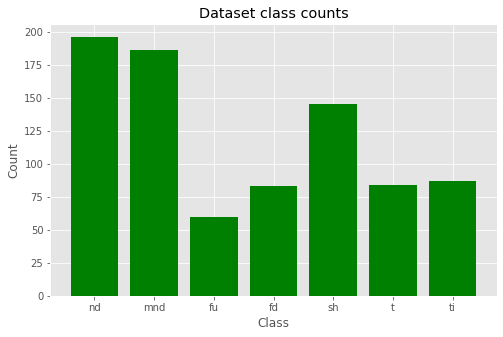

In [7]:
# Plot a chart of the class counts in the training set
show_class_counts(y_train, gestures)

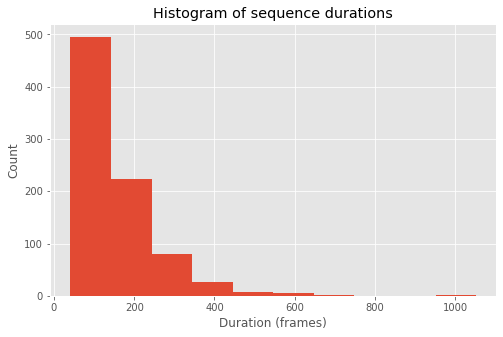

In [8]:
# Plot a histogram of gesture durations
show_durations(X_train)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
def pre(XX):
    XX = seq.preprocessing.filtrate(XX, n=10, method='median')
    XX = smart_downsample(XX, m=50, method='decimate')
    XX = seq.preprocessing.center(XX)
    return XX

In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(10, 5), same_scale=True, title=None):
    title = "Head rotation and translation vectors for a '{}' gesture".format(gestures_map[label]) if title is None else title
    labels = ['$R_x$ (Roll)', '$R_y$ (Yaw)', '$R_z$ (Pitch)', '$T_x$', '$T_y$', '$T_z$']
    colors = ['blue', 'red', 'green'] * 2
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=figsize)
    
    for i in range(3):
        ax1, ax2 = axs[i, 0], axs[i, 1]
        ax1.plot(gesture[:, i], label=labels[i], color=colors[i])
        ax2.plot(gesture[:, i+3], label=labels[i+3], color=colors[i+3])
        ax1.legend(loc='lower right')
        ax2.legend(loc='lower right')
        if same_scale:
            pad = 0.1
            ax1.set_ylim(gesture.min()-pad, gesture.max()+pad)
            ax2.set_ylim(gesture.min()-pad, gesture.max()+pad)
            
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.suptitle(title)
    plt.show()

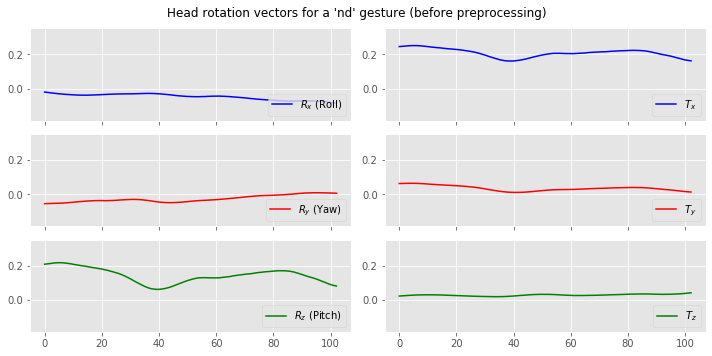

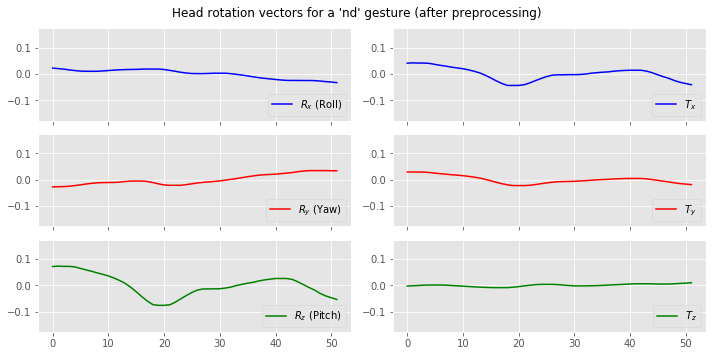

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[0], y_train[0]
plot_gesture(x_sample, y_sample, title="Head rotation vectors for a '{}' gesture (before preprocessing)".format(y_sample))
plot_gesture(pre(x_sample), y_sample, title="Head rotation vectors for a '{}' gesture (after preprocessing)".format(y_sample))

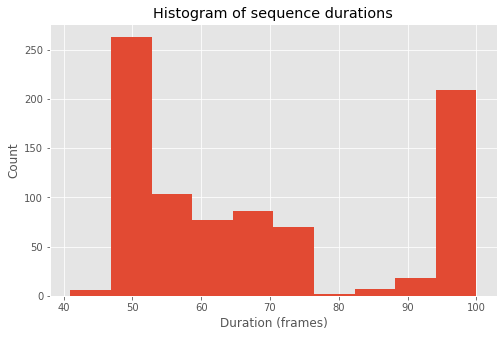

In [12]:
# Transform training data and plot histogram of signal durations
Xp_train = pre(X_train)
show_durations(Xp_train)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre(X_val), pre(X_test)

## DTWKNN classifier

### Fitting the model

In [14]:
%%time
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clfs['knn'] = DTWKNN(k=1, radius=1)
clfs['knn'].fit(Xp_train, y_train)

CPU times: user 4.53 ms, sys: 1.87 ms, total: 6.4 ms
Wall time: 7.02 ms


### Evaluating the model

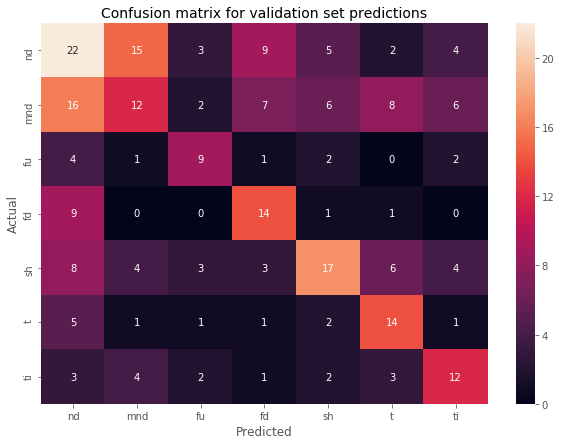

Accuracy: 38.76%
CPU times: user 847 ms, sys: 374 ms, total: 1.22 s
Wall time: 36min 54s


In [15]:
%%time
results['knn']['validation'] = clfs['knn'].evaluate(Xp_val, y_val, labels=gestures, n_jobs=-1)
show_results(*results['knn']['validation'], dataset='validation', labels=gestures)

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Fitting the model

In [16]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for g in tqdm(gestures, desc='Training HMMs'):
    hmm = HMM(label=g, n_states=7, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([Xp_train[i] for i, label in enumerate(y_train) if label == g])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clfs['hmm'] = HMMClassifier()
clfs['hmm'].fit(hmms)


CPU times: user 26.4 s, sys: 329 ms, total: 26.7 s
Wall time: 29.6 s


### Evaluating the model

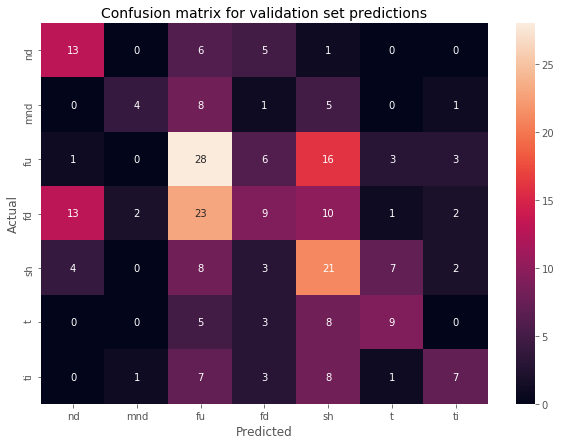

Accuracy: 35.27%
CPU times: user 1.11 s, sys: 54.8 ms, total: 1.17 s
Wall time: 1.27 s


In [17]:
%%time
results['hmm']['validation'] = clfs['hmm'].evaluate(Xp_val, y_val)
show_results(*results['hmm']['validation'], dataset='validation', labels=gestures)

In [18]:
with np.printoptions(precision=3, suppress=True):
    display(hmms[0].initial, hmms[0].transitions)

array([0.015, 0.305, 0.062, 0.135, 0.026, 0.263, 0.194])

array([[0.952, 0.016, 0.   , 0.032, 0.   , 0.   , 0.   ],
       [0.   , 0.99 , 0.001, 0.001, 0.   , 0.002, 0.005],
       [0.   , 0.   , 0.967, 0.012, 0.003, 0.018, 0.   ],
       [0.   , 0.   , 0.   , 0.986, 0.002, 0.011, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.975, 0.025, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.996, 0.004],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

## LSTM classifier

### Fitting the model

In [19]:
%%time
from tensorflow.keras.optimizers import Adam
clfs['lstm'] = LSTMClassifier(epochs=150, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clfs['lstm'].fit(Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True)

Train on 841 samples, validate on 258 samples
Epoch 1/150
841/841 [==============================] - 5s 6ms/sample - loss: 1.9383 - accuracy: 0.1879 - val_loss: 1.9184 - val_accuracy: 0.2248
Epoch 2/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.9178 - accuracy: 0.2283 - val_loss: 1.8798 - val_accuracy: 0.2558
Epoch 3/150
841/841 [==============================] - 3s 3ms/sample - loss: 1.8916 - accuracy: 0.2200 - val_loss: 1.8896 - val_accuracy: 0.2209
Epoch 4/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8843 - accuracy: 0.2342 - val_loss: 1.8709 - val_accuracy: 0.2248
Epoch 5/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8641 - accuracy: 0.2295 - val_loss: 1.8570 - val_accuracy: 0.2326
Epoch 6/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8608 - accuracy: 0.2461 - val_loss: 1.8534 - val_accuracy: 0.2248
Epoch 7/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.8539 

Epoch 57/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.5863 - accuracy: 0.3817 - val_loss: 1.6851 - val_accuracy: 0.3488
Epoch 58/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.6088 - accuracy: 0.3508 - val_loss: 1.6876 - val_accuracy: 0.3605
Epoch 59/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.5950 - accuracy: 0.3674 - val_loss: 1.7843 - val_accuracy: 0.3333
Epoch 60/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.6491 - accuracy: 0.3460 - val_loss: 1.6857 - val_accuracy: 0.3140
Epoch 61/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.6302 - accuracy: 0.3508 - val_loss: 1.7383 - val_accuracy: 0.2713
Epoch 62/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.6441 - accuracy: 0.3615 - val_loss: 1.7095 - val_accuracy: 0.3295
Epoch 63/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.5995 - accuracy: 0.3674 - val_loss: 1.7149 -

841/841 [==============================] - 2s 3ms/sample - loss: 1.4327 - accuracy: 0.4566 - val_loss: 1.7302 - val_accuracy: 0.3488
Epoch 114/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.4078 - accuracy: 0.4495 - val_loss: 1.6599 - val_accuracy: 0.3953
Epoch 115/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.3783 - accuracy: 0.4768 - val_loss: 1.7004 - val_accuracy: 0.3566
Epoch 116/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.3835 - accuracy: 0.4602 - val_loss: 1.6327 - val_accuracy: 0.4031
Epoch 117/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.3228 - accuracy: 0.4804 - val_loss: 1.6944 - val_accuracy: 0.4070
Epoch 118/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.3598 - accuracy: 0.4744 - val_loss: 1.6939 - val_accuracy: 0.3798
Epoch 119/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.3151 - accuracy: 0.4970 - val_loss: 1.6284 - val_ac

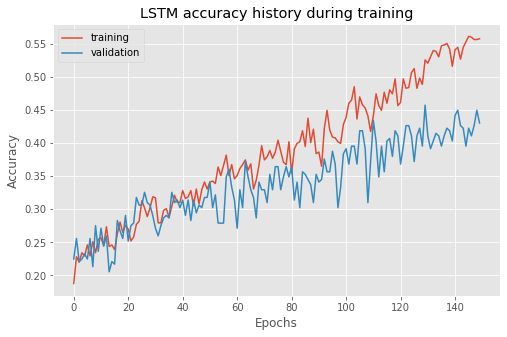

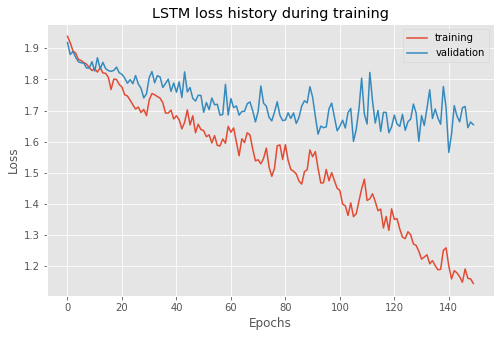

In [20]:
# Display accuracy and loss history during training
show_accuracy_history(hist)
show_loss_history(hist)

### Evaluating the model

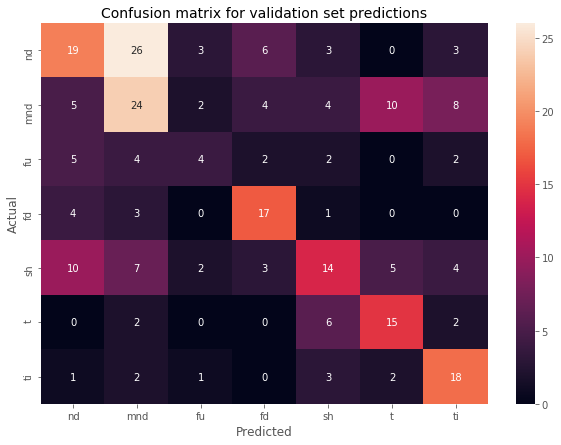

Accuracy: 43.02%
CPU times: user 1.49 s, sys: 103 ms, total: 1.59 s
Wall time: 1.86 s


In [21]:
%%time
results['lstm']['validation'] = clfs['lstm'].evaluate(Xp_val, y_val)
show_results(*results['lstm']['validation'], dataset='validation', labels=gestures)